In [214]:
import numpy as np
import pandas as pd
import yfinance as yf
import sklearn
from scipy.stats import norm
import matplotlib.pyplot as plt
import math

In [215]:
# Define the stock and date range
start = '1980-01-01'
end = '2024-10-15'
stock = '^GSPC'

# Download the stock data
yfd = yf.download(stock, start=start, end=end)

# Prepare the DataFrame
df = pd.DataFrame({'Close': yfd['Close']})
df = df.dropna().reset_index(drop=True)
print(df[-10:])

[*********************100%***********************]  1 of 1 completed

             Close
11281  5708.750000
11282  5709.540039
11283  5699.939941
11284  5751.069824
11285  5695.939941
11286  5751.129883
11287  5792.040039
11288  5780.049805
11289  5815.029785
11290  5859.850098


# Visualize The Data

[[ 105.76000214]
 [ 105.22000122]
 [ 106.51999664]
 ...
 [5780.04980469]
 [5815.02978516]
 [5859.85009766]] (11291, 1)
(11291,) (11291,)


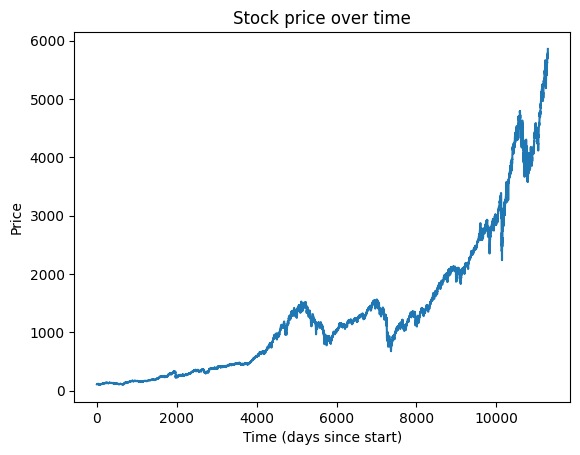

In [216]:
df = np.array(df)
index = np.linspace(1, df.shape[0], df.shape[0])

print(df, df.shape)
print(index.shape, df.T[0].shape)

plt.plot(index, df.T[0])
plt.title("Stock price over time")
plt.xlabel('Time (days since start)')
plt.ylabel('Price')
plt.show()


# Split the data into bins

In [1]:
bin_size = 365 # We require the past year of data

bins = np.array([df[i:i + bin_size].T.reshape(-1) for i in range(0, len(df) - bin_size - 1, 1)])

print(bins.shape)
print(bins[0][:5], bins[0].shape)
print(bins[1][:5], bins[1].shape)
print(bins[2][:5], bins[2].shape)
print(bins[3][:5], bins[3].shape)
print(bins[4][:5], bins[4].shape)

print(bins[-1][-10:])


NameError: name 'np' is not defined

# Split Data: Train and Test

In [201]:
# Generally it is good practice to train data on 80 % of the data and test on 20%
train_size = math.floor(len(bins)* 0.8) # 80% of the data
test_size = len(bins) - train_size # 20% of the data
assert train_size + test_size == len(bins)

# split into X and y
X_train = np.array(bins[:train_size])
y_train = np.array(df[1:train_size + 1]).T.reshape(-1)
train_index = index[:train_size]

X_test = np.array(bins[train_size:])
y_test = np.array(df[train_size + 1: train_size + 1 + test_size]).T.reshape(-1)
test_index = index[train_size + 1: train_size + 1 + test_size]

print("train_size:", train_size)
print("test_size:", test_size)
print("x_size:", X_train.shape, X_test.shape)
print("y_size:", y_train.shape, y_test.shape)


train_size: 8739
test_size: 2185
x_size: (8739, 365) (2185, 365)
y_size: (8739,) (2185,)


# Train the linear model

In [202]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
print(model.coef_) # weights
print(model.intercept_) # bias

[-8.81114251e-14  1.00000000e+00 -4.26325641e-14  1.52933222e-14
  1.86517468e-14  1.14630527e-14 -2.77555756e-17 -3.68038933e-14
  9.63118474e-14 -4.32431868e-14  3.22519789e-14 -3.00315328e-14
 -7.47180096e-14 -9.15933995e-16 -4.44644321e-14  6.30329122e-14
 -3.25017790e-14  7.40657535e-14 -4.22717417e-14  7.56616991e-14
  4.32154312e-14 -4.68514116e-14 -8.40022496e-14  1.90958360e-14
 -1.25316424e-14 -4.49293380e-14  9.45424294e-14 -2.10057666e-14
 -6.02194076e-14  3.04079678e-14  3.66143747e-14  4.97778901e-15
  8.89999879e-15 -1.17614252e-14  4.85375629e-14 -3.32338324e-14
 -4.51860771e-14  7.10889680e-15 -1.45126966e-14  1.33608402e-14
 -2.55039045e-14  7.76774478e-14  3.16136006e-14 -1.34656175e-13
  4.15258106e-14  5.71764858e-15  3.07340958e-14  2.95041769e-14
 -2.30163111e-14 -1.71251902e-14  3.57006091e-14 -5.87585536e-14
 -3.02726594e-14 -3.54664215e-15  1.72847847e-14  5.71209746e-14
 -1.10189635e-14  4.74308093e-14 -3.19640148e-14  7.10681514e-14
 -1.54718252e-13  4.92626

In [203]:
# now we make some predictions
# y_pred = 0
# for i in range(len(y_test)):
#     y_pred = model.predict([X_test[i]])
#     print(y_pred, y_test[i])

y_pred = np.floor(model.predict(X_test))
y_test = np.floor(y_test)
print(y_pred.shape, y_test.shape)

for i in range(math.floor(len(y_pred) * 0.01)):
    print(y_pred[i], y_test[i])
# print(y_pred)


(2185,) (2185,)
2000.0 2000.0
2000.0 2000.0
1996.0 1996.0
2003.0 2003.0
2002.0 2002.0
2000.0 2000.0
1997.0 1997.0
2007.0 2007.0
2001.0 2001.0
1988.0 1988.0
1995.0 1995.0
1997.0 1997.0
1985.0 1985.0
1984.0 1984.0
1998.0 1998.0
2001.0 2001.0
2011.0 2011.0
2010.0 2010.0
1994.0 1994.0
1982.0 1982.0
1998.0 1998.0


(8739,) (2185,)


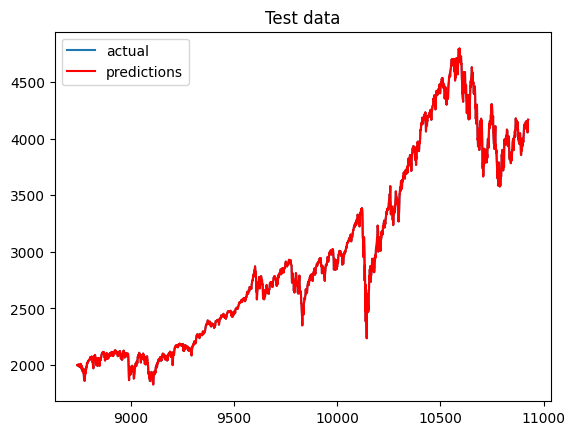

Correctly Classified: 2171/2185
Accuracy: 99.35926773455378%


In [204]:
print(train_index.shape, test_index.shape)
plt.plot(test_index, y_test, label="actual")
plt.plot(test_index, y_pred, color="red", label="predictions")
plt.title("Test data")
plt.legend()
plt.show()

results = y_pred == y_test
print(f"Correctly Classified: {np.sum(results)}/{len(results)}")
print(f"Accuracy: {100 * np.sum(results) / len(results)}%")


In [212]:
print(f"Tomorrows Price: {y_pred[-1]}")
print(y_pred[-15:])

Tomorrows Price: 4167.0
[4108. 4091. 4146. 4137. 4151. 4154. 4154. 4129. 4133. 4137. 4071. 4055.
 4135. 4169. 4167.]
